#LSTM AND BI-LSTM for Temperature Prediction

In [2]:
# pip install 

In [1]:
# import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
# from google.colab import files
# mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['axes.grid'] = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


/Users/ange-clementakazan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


**Data Importation and Information**

In [2]:
# data for Abidjan
Abj_dt = pd.read_csv('/Users/ange-clementakazan/Documents/Weather_Prediction_project/Deep-Learning-for-Weather-Prediction/data/Abidjan_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})
# data for Kigali
Kgl_dt = pd.read_csv('/Users/ange-clementakazan/Documents/Weather_Prediction_project/Deep-Learning-for-Weather-Prediction/data/Kigali_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})

# print(df.info())
# df.describe(),data_.describe()
# df.head(4) 

/var/folders/nv/ct8x_h9j78xbj8gnyb35c3_w0000gn/T/ipykernel_84374/538562530.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  Abj_dt = pd.read_csv('/Users/ange-clementakazan/Documents/Weather_Prediction_project/Deep-Learning-for-Weather-Prediction/data/Abidjan_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})
/var/folders/nv/ct8x_h9j78xbj8gnyb35c3_w0000gn/T/ipykernel_84374/538562530.py:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  Kgl_dt = pd.read_csv('/Users/ange-clementakazan/Documents/Weather_Prediction_project/Deep-Learning-for-Weather-Prediction/data/Kigali_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})


In [3]:
##### No missing for both datasets ###
# Abj_dt.isna().sum()
# Kgl_dt.isnull().sum()
Abj_dt.columns


Index(['datetime', 'ALLSKY_SFC_SW_DWN', 'CLRSKY_SFC_SW_DWN',
       'ALLSKY_SFC_LW_DWN', 'T2M', 'T2MDEW', 'T2MWET', 'QV2M', 'RH2M',
       'PRECTOTCORR', 'PS'],
      dtype='object')

In [4]:
#Rename Columns
col_name_map = {
    "ALLSKY_SFC_SW_DWN": "ASWD",
    "CLRSKY_SFC_SW_DWN":"CSWD","ALLSKY_SFC_LW_DWN":"ALWD","PRECTOTCORR":"PREC"
}
# new_colnames=['datetime', 'ASWD', 'CSWD',
#        'ALWD', 'T2M', 'T2MDEW', 'T2MWET', 'QV2M', 'RH2M',
#        'PREC', 'PS']
# Rename the columns for both datasets
Abj_dt=Abj_dt.rename(columns=col_name_map)
Kgl_dt=Kgl_dt.rename(columns=col_name_map)



In [5]:
# print(Abj_dt.info())
print(Kgl_dt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5114 entries, 0 to 5113
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  5114 non-null   datetime64[ns]
 1   ASWD      5114 non-null   float64       
 2   CSWD      5114 non-null   float64       
 3   ALWD      5114 non-null   float64       
 4   T2M       5114 non-null   float64       
 5   T2MDEW    5114 non-null   float64       
 6   T2MWET    5114 non-null   float64       
 7   QV2M      5114 non-null   float64       
 8   RH2M      5114 non-null   float64       
 9   PREC      5114 non-null   float64       
 10  PS        5114 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 439.6 KB
None


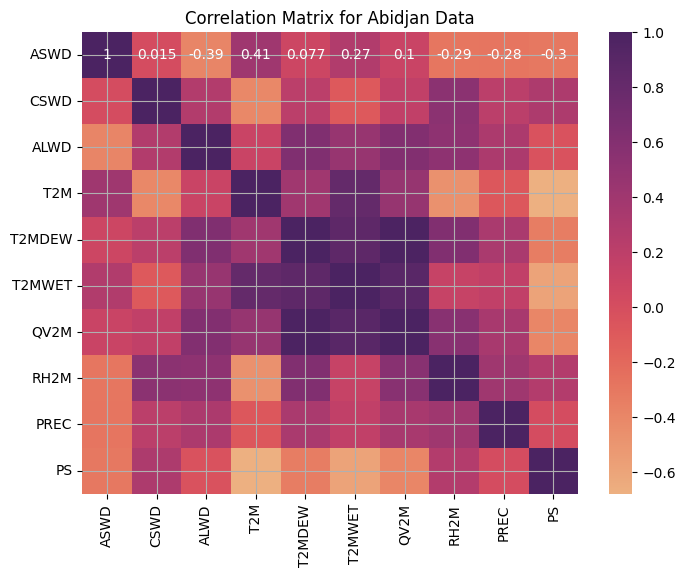

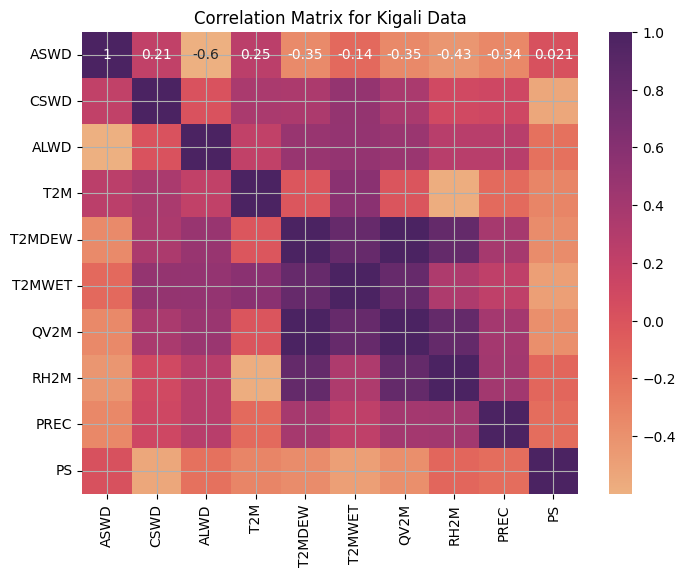

In [6]:
# df.columns,df_.columns
def displayHeatMap(dim1, dim2, title, df):
    fig=plt.figure(figsize=(dim1,dim2))
    plt.title(title)
    sns.heatmap(df, annot= True, cmap='flare')
# Define correlation matrix for both data
corr_Abj= Abj_dt.iloc[:,1:].corr()
corr_Kgl= Kgl_dt.iloc[:,1:].corr()
# Display the heatmap
displayHeatMap(8, 6,"Correlation Matrix for Abidjan Data",corr_Abj)
displayHeatMap(8, 6,"Correlation Matrix for Kigali Data",corr_Kgl)

In [7]:
Abj_dt=Abj_dt.set_index("datetime")
Kgl_dt=Kgl_dt.set_index("datetime")

In [8]:
# Abj_dt

**Variable ploting**

/Users/ange-clementakazan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ange-clementakazan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ange-clementakazan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


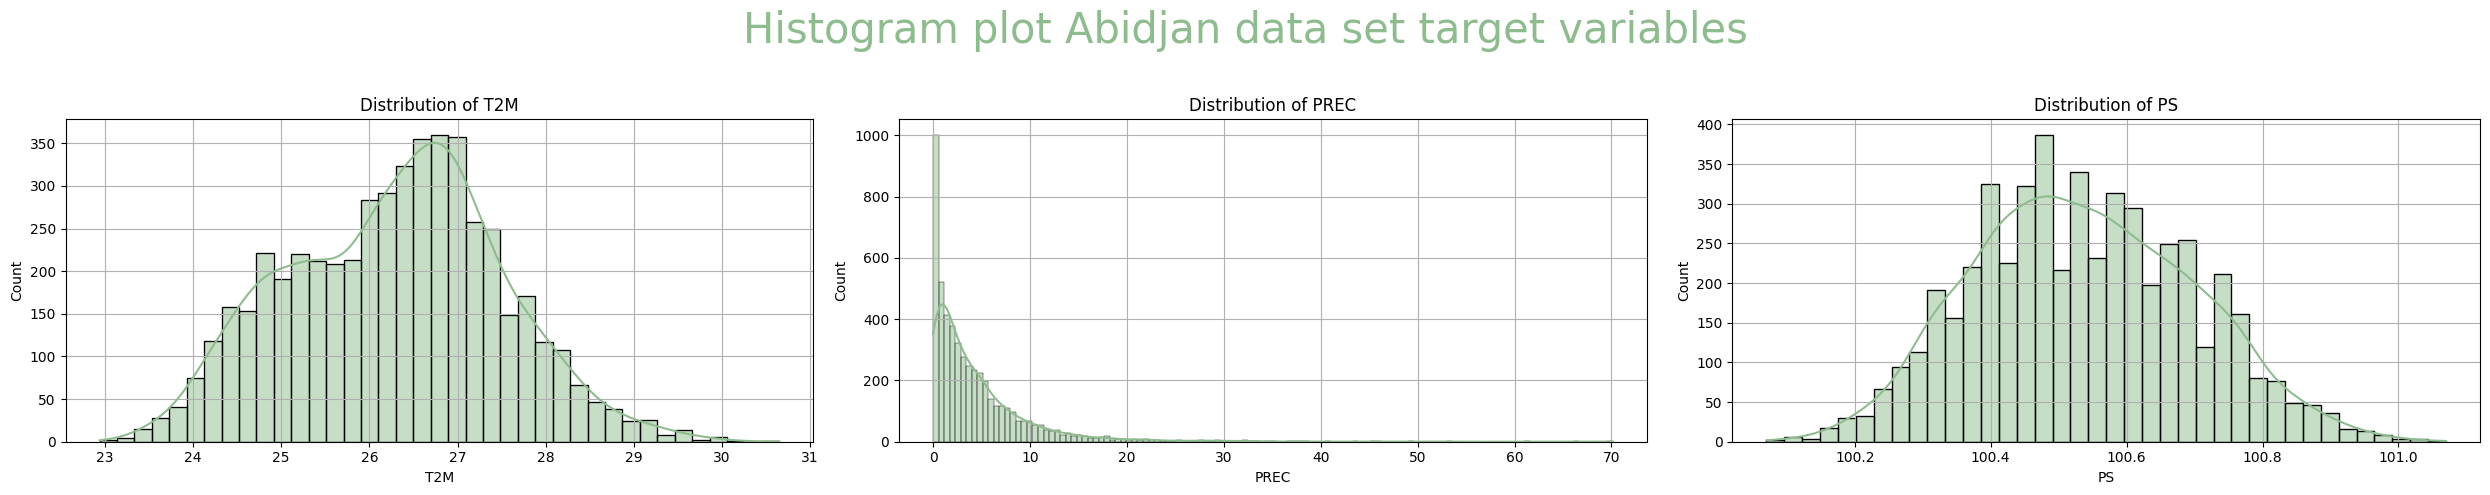

In [9]:
# df['Days'] = pd.to_datetime(df['Days'], dayfirst=True)
# df.index = pd.to_datetime(df['Days'],infer_datetime_format=True )
# plt.figure(figsize=(9,9))
# df.set_index('Days')[['T2M', 'WS2M', 'PREC', 'RH2M', 'QV2M',
#        'CSSWDW', 'T2MDEW', 'ALLSKYDW']].plot(subplots=True)
#plotting histograms of each category to idenitfy patterns in the data

def showDistributions(df,categories,per_column=True,color="darkseagreen",title="Original Data"):
    if per_column:
        fig, axes = plt.subplots(1,len(categories), figsize=(25, 5))
        for i in range(len(categories)):
            sns.histplot(data=df, x=categories[i], kde=True, color=color, ax=axes[i])
            axes[i].set_title("Distribution of {}".format(categories[i]))
        plt.suptitle(f'{title}', fontsize=30,  color=color)
        # Adjust layout to make room for the general title
        plt.tight_layout(rect=[0, 0, 1, 0.95],)
    else:
        fig, axes = plt.subplots(1,1, figsize=(8, 5))
        sns.histplot(data=df, x=None, kde=True, color=color, ax=axes)
        axes.set_title("Distribution of {}".format(title))

showDistributions(Abj_dt,["T2M","PREC","PS"],title="Histogram plot Abidjan data set target variables")

/Users/ange-clementakazan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ange-clementakazan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ange-clementakazan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


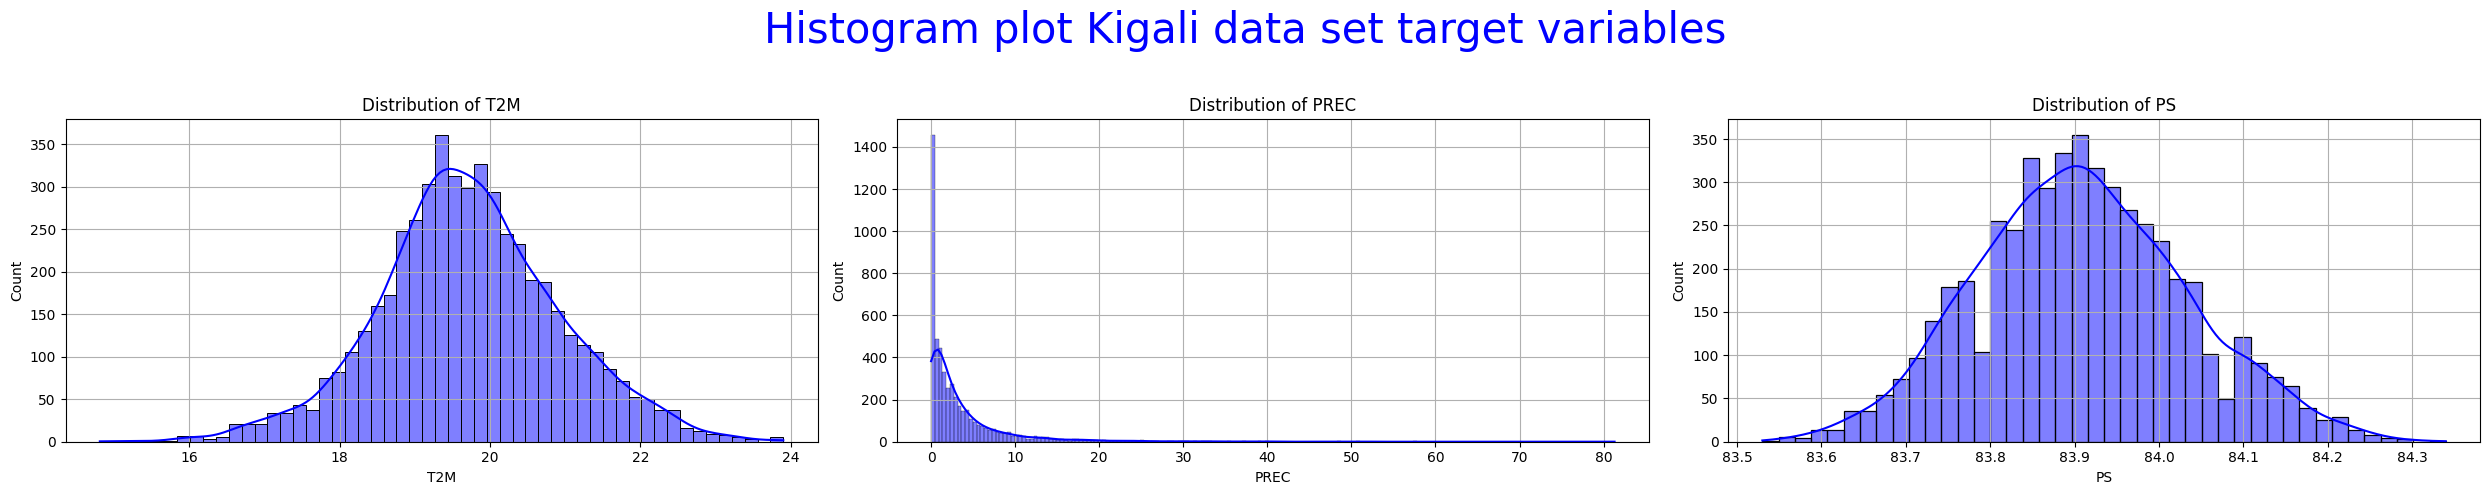

In [10]:
#Handle missing values
showDistributions(Kgl_dt,["T2M","PREC","PS"],color="blue",title="Histogram plot Kigali data set target variables")
# df = df.fillna(method='ffill')  # Forward fill for simplicity, or use df.dropna() to remove rows with NaNs
# print(df.isnull().sum())  # Verify no missing values remain


In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
kgl=Kgl_dt[['PREC','PS']][:10]
kgl[['PREC','PS']]=scaler.fit_transform(kgl)

In [12]:
kgl
# dt

,PREC,PS
datetime,,
2010-01-01,0.081349,0.428571
2010-01-02,0.053571,1.000000
2010-01-03,0.000000,0.857143
2010-01-04,0.053571,0.500000
2010-01-05,0.223214,0.357143
2010-01-06,0.581349,0.000000
2010-01-07,0.050595,0.071429
2010-01-08,0.133929,0.428571
2010-01-09,0.018849,0.928571


In [13]:
#################### Datapreprocessing For Temperature   #####################

# Sorting the dates
# Kgl_dt_input= Kgl_dt.sort_index()
# Abj_dt_input= Abj_dt.sort_index()
# Scalling
# scaler = MinMaxScaler()
def Make_tidydata(data,scaler):
    data= data.sort_index()
    data[data.columns] = scaler.fit_transform(data[data.columns])
    # Splitting the dataset into training, validation, and test sets
    train_size = int(len(data)*0.8)
    val_size =int(train_size*0.10)
    #Train_val_test sets
    Xy_train = data[:train_size-val_size]
    Xy_val= data[train_size-val_size:train_size]
    Xy_test=data[train_size:]
    return Xy_train,Xy_val,Xy_test

# Define the TimeSeriesDataset class
# class TimeSeriesDataset(Dataset):
#     def __init__(self, features, target, window_length):
#         self.features = features
#         self.target = target
#         self.window_length = window_length
#     def __len__(self):
#         return len(self.features) - self.window_length
#     def __getitem__(self, idx):
#         X = self.features[idx:idx + self.window_length]
#         y = self.target[idx + self.window_length]
#         return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
## Define the TimeSeriesDataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe, n_steps_in, n_steps_out,target_names):
        """
        Initialize the dataset with a pandas DataFrame.
        Parameters:
        - dataframe: Pandas DataFrame containing the time series data.
        - n_steps_in: Number of time steps for input.
        - n_steps_out: Number of time steps for output.
        -target_names: NAmes of the target variables.
        """
        self.dataframe = dataframe
        self.n_steps_in = n_steps_in
        self.n_steps_out = n_steps_out   
        self.target_names=target_names   
        # Prepare the input and output sequences
        self.X, self.y = self.sliding_window(self.dataframe, self.n_steps_in, self.n_steps_out,self.target_names)
    def sliding_window(self, dataframe, n_steps_in, n_steps_out,target_names):
        X, y = list(), list()  
        for i in range(len(dataframe)):
            end_idx = i + n_steps_in
            out_end_idx = end_idx + n_steps_out - 1
            # Ensure valid index range
            if out_end_idx >= len(dataframe):
                break
            # Extract X and y sequences
            seq_x = dataframe.iloc[i:end_idx, :].values  # X sequence
            seq_y = dataframe[target_names][end_idx:out_end_idx + 1].values  # y sequence (last column)| Redefine this!!!
            # Check if `seq_y` is shorter than `n_steps_out`
            if len(seq_y) < n_steps_out:
                pad_length = n_steps_out - len(seq_y)
                avg_value = np.mean(seq_y)  # Calculate the average of `seq_y`
                # Pad `seq_y` with the average value
                seq_y = np.pad(seq_y, (0, pad_length), 'constant', constant_values=avg_value)
            # Ensure `seq_y` is a 2D array
            if len(seq_y.shape) == 1:
                seq_y = seq_y.reshape(-1, 1)
            # Append the sequences to the list
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        # Return the input-output pair for the given index
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
    
# Create data loaders
def create_data_loaders(TimeSeriesDataset,Make_tidydata,df,target_names,scaler,window_length,obs_length,batch_size):
    Xy_train,Xy_val,Xy_test=Make_tidydata(df,scaler)
    # Creating time series data
    train_dataset = TimeSeriesDataset(Xy_train,obs_length, window_length,target_names)
    val_dataset = TimeSeriesDataset(Xy_val, obs_length, window_length,target_names)
    test_dataset = TimeSeriesDataset(Xy_test, obs_length, window_length,target_names)
    # Creating data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader,val_loader,test_loader

# Create DataLoaders for Abidjan and Kigali
batch_size = 64
window_length = 1
obs_length=14
scaler=[MinMaxScaler(feature_range=(0,1)),MinMaxScaler(feature_range=(0,1))]
target_names=['T2M','PREC','PS']
Abj_train_loader,Abj_val_loader,Abj_test_loader=create_data_loaders(TimeSeriesDataset,Make_tidydata,Abj_dt,target_names,scaler[0],window_length,obs_length,batch_size)
Kgl_train_loader,Kgl_val_loader,Kgl_test_loader=create_data_loaders(TimeSeriesDataset,Make_tidydata,Kgl_dt,target_names,scaler[1],window_length,obs_length,batch_size)

# Models 

In [27]:
########################################################################################################################
#####################################  Recurrent Network Model for    Temperature prediction       #################################
########################################################################################################################

#LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()       
        # Define LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)       
        # Define Dropout layer
        self.dropout = nn.Dropout(dropout_prob)   
        # Define Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)       
    def forward(self, x):
        # Forward pass through LSTM
        lstm_out, _ = self.lstm(x)     
        # _, (h_n, _) = self.lstm(x)  # Only use the last hidden state
        # h_n = h_n[-1]  
        # Apply dropout to LSTM output
        lstm_out = self.dropout(lstm_out[ :,-1, :])  # Use the output of the last time step   ||| We wiil try to extract the last hidden layer instead h_n[-1,:,:]    
        # Forward pass through Dense layer
        out = self.fc(lstm_out)
        return out
    
#GRU
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()       
        # Define LSTM layer
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)       
        # Define Dropout layer
        self.dropout = nn.Dropout(dropout_prob)   
        # Define Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)       
    def forward(self, x):
        # Forward pass through LSTM
        gru_out, _ = self.gru(x)      
        # Apply dropout to LSTM output
        gru_out = self.dropout(gru_out[:, -1, :])  # Use the output of the last time step       
        # Forward pass through Dense layer
        out = self.fc(gru_out)
        return out
#BiLSTM
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.2):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                            bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional

    def forward(self, x):
        h_lstm, _ = self.lstm(x)
        out = self.fc(h_lstm[:, -1, :])  # Use the output of the last time step
        return out
#BiGRU
class BiGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.2):
        super(BiGRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, 
                          bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional

    def forward(self, x):
        h_gru, _ = self.gru(x)
        out = self.fc(h_gru[:, -1, :])  # Use the output of the last time step
        return out
# Ensemble
class MyEnsemble(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(MyEnsemble, self).__init__()
        self.lstm_model = LSTMModel(input_dim , hidden_dim, output_dim, dropout_prob=0.2).to(device)
        self.gru_model = GRUModel(input_dim, hidden_dim, output_dim, dropout_prob=0.2).to(device)
        self.bilstm = BiLSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)
        self.bigrus=BiGRU(input_dim, hidden_dim, output_dim, num_layers).to(device)
        self.weights = nn.Parameter(torch.ones(4))
    def forward(self, x):
        weights_normalized = F.softmax(self.weights, dim=0)
        lstm_out = self.lstm_model(x)
        gru_out = self.gru_model(x)
        bilstm_out = self.bilstm(x)
        bigru_out = self.bigrus(x)
        # Combine the outputs (e.g., by averaging them)
        ensemble_out = weights_normalized [0]*lstm_out + weights_normalized [1]*gru_out + weights_normalized [2]*bigru_out + weights_normalized [3]*bilstm_out 
        return ensemble_out
    

# Early Stopping Function

In [28]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=50, mode='min', verbose=False, delta=0, save_path=None):
        self.patience = patience
        self.mode = mode
        self.verbose = verbose
        self.delta = delta  # Added delta to ignore small improvements
        self.save_path = save_path  # Path to save the best model
        self.best_score = np.inf if mode == 'min' else -np.inf
        self.early_stop = False
        self.counter = 0

    def __call__(self, score, model=None):
        if self.mode == 'min':
            # Check if the score has decreased significantly
            if score < self.best_score - self.delta:
                self.best_score = score
                self.counter = 0
                if self.verbose:
                    print(f'Validation loss decreased ({self.best_score:.6f} --> {score:.6f}). Saving model...')
                if model and self.save_path:
                    torch.save(model.state_dict(), self.save_path)
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
                    if self.verbose:
                        print(f'Early stopping triggered after {self.patience} epochs with no improvement.')

        elif self.mode == 'max':
            # Check if the score has increased significantly
            if score > self.best_score + self.delta:
                self.best_score = score
                self.counter = 0
                if self.verbose:
                    print(f'Validation metric increased ({self.best_score:.6f} --> {score:.6f}). Saving model...')
                if model and self.save_path:
                    torch.save(model.state_dict(), self.save_path)
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
                    if self.verbose:
                        print(f'Early stopping triggered after {self.patience} epochs with no improvement.')


# Model Initialization

In [84]:
# Initialize models
input_dim = Abj_dt.shape[1]
hidden_dim = 94
output_dim = len(target_names)
num_layers = 2
#LSTM
model_lstm = LSTMModel(input_dim, hidden_dim, output_dim, dropout_prob=0.2).to(device)
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=0.001)
#GRU
model_gru= GRUModel(input_dim, hidden_dim, output_dim, dropout_prob=0.2).to(device)
optimizer_gru = optim.Adam(model_gru.parameters(), lr=0.001)
# For BiLSTM
model_bilstm = BiLSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)
optimizer_bilstm = optim.Adam(model_bilstm.parameters(), lr=0.001)

# For BiGRU
model_bigrus = BiGRU(input_dim, hidden_dim, output_dim, num_layers).to(device)
optimizer_bigrus = optim.Adam(model_bigrus.parameters(), lr=0.001)


ens_model=MyEnsemble(input_dim, hidden_dim, output_dim, num_layers).to(device)
optimizer_ens = optim.Adam(ens_model.parameters(), lr=0.001)


In [85]:
optimizer_lstm 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [78]:
t=torch.Tensor([2,1])
p=torch.Tensor([2,1])
torch.nn.MSELoss()(t,p)
# t.item()

tensor(0.)

# Training Functions

In [120]:

# Initialize early stopping
patience=200
# Define the loss function and optimizer
criterion = [torch.nn.MSELoss() for i in range(len(target_names))]
# class Sum_Mse():
#     def __init__(self,data1, data2,mse):
#         self.mse=[]
# class LineSumMSE(nn.Module):
#     def __init__(self):
#         super(LineSumMSE, self).__init__()
#     def forward(self, output, target):
#         squared_diff = (output-target)**2
#         line_sums = squared_diff.sum(dim=1)
#         mse_loss = line_sums.mean()
#         return mse_loss
    
# criterion = LineSumMSE( )
 
#Define metrics
def rmse(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2,0))
def mse(predictions, targets):
    return torch.mean((predictions - targets) ** 2,0)
def mae(predictions, targets):
    return torch.mean(torch.abs(predictions - targets),0)
# Training function
def training_function(model,train_loader,val_loader,optimizer,num_epochs=160):
    train_losses=[]
    val_losses = []
    final_losses=[]
    early_stopping = EarlyStopping(patience=patience, mode='min', verbose=True)
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_mse = 0.0
        running_mae = 0.0  
        # Training phase
        for X_batch, y_batch in train_loader:
            X_batch,y_batch=X_batch.to(device),y_batch.to(device).squeeze()
            optimizer.zero_grad()
            # output1,output2,output3 = model(X_batch)
            # y1,y2,y3=y_batch
            # loss
            loss=0
            for i in range(y_batch.shape[1]):
                o_i=model(X_batch)[:,i]
                y_i=y_batch[:,i]
                loss_i=criterion[i](o_i,y_i)
                loss+=loss_i
            # print("output size:",outputs.shape,"y_batch:",y_batch.shape )
            # loss = criterion(outputs, y_batch)    
            # loss=torch.mean((outputs-y_batch)**2,axis=0)
            # print()
            loss.backward()
            optimizer.step()
            # print("loss:",loss,"loss shape:",loss.shape)
            running_loss += loss * X_batch.size(0)  
            outputs = model(X_batch)    
            running_mse += rmse(outputs, y_batch) * X_batch.size(0)
            running_mae += mae(outputs, y_batch) * X_batch.size(0)
        # Cumulative training loss 
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_mse = running_mse / len(train_loader.dataset)
        epoch_train_mae = running_mae / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        # Validation phase 
        model.eval() # Set model to validation model
        val_loss = 0.0
        val_mse = 0.0
        val_mae = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch,y_batch=X_batch.to(device),y_batch.to(device).squeeze()
                outputs = model(X_batch)
                # o_l2=torch.norm(outputs)
                # y_l2=torch.norm(y_batch)
                # print("output_norm:",o_l2,"y_norm:",y_l2 )
                # loss = criterion(outputs, y_batch)
                # loss_=torch.mean((outputs-y_batch)**2,axis=0)
                # val_loss += loss_* X_batch.size(0)
                val_mse += mse(outputs, y_batch) * X_batch.size(0)
                val_mae += mae(outputs, y_batch) * X_batch.size(0)
        # Cumulative validation loss 
        # epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_mse = val_mse / len(val_loader.dataset)
        epoch_val_mae = val_mae / len(val_loader.dataset)
        val_losses.append(epoch_val_mse)
        if (epoch+1) %5==0:
            # Print losses and metrics
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Combined Loss:{epoch_train_loss:.4f}, Training Loss: {epoch_train_mse}, MAE: {epoch_train_mae}') #,
            print(f'Validation Loss: {epoch_val_mse}, MAE: {epoch_val_mae}') # MSE: {epoch_val_loss}
            # print(f'Training Loss: {epoch_train_loss}, MSE: {epoch_train_mse}, MAE: {epoch_train_mae}') #:.4f
            # print(f'Validation Loss: {epoch_val_loss}, MSE: {epoch_val_mse}, MAE: {epoch_val_mae}')
            print('------------------------------------')  
        # Check early stopping
        early_stopping(torch.mean(epoch_val_mse))
        if early_stopping.early_stop:
            print('Early stopping')
            break
        #[epoch_train_loss,epoch_train_mse,epoch_train_mae]
    final_losses.append([[epoch_train_loss,epoch_train_mse,epoch_train_mae],[epoch_val_mse,epoch_val_mae]])
    return train_losses, val_losses,final_losses

In [121]:
# [2,2]*3
# np.sum([0.0561, 0.0518, 0.0677])/3

In [122]:
#Ensemble model
# history_ens=training_function(ens_model,Abj_train_loader,Abj_val_loader,optimizer_ens ,num_epochs=2)
history_lstm=training_function(model_lstm,Abj_train_loader,Abj_val_loader,optimizer_lstm ,num_epochs=30)

Validation loss decreased (0.003432 --> 0.003432). Saving model...
Epoch 5/30
Combined Loss:0.0098, Training Loss: tensor([0.0516, 0.0500, 0.0619], grad_fn=<DivBackward0>), MAE: tensor([0.0399, 0.0332, 0.0495], grad_fn=<DivBackward0>)
Validation Loss: tensor([0.0029, 0.0037, 0.0038]), MAE: tensor([0.0409, 0.0382, 0.0503])
------------------------------------
Epoch 10/30
Combined Loss:0.0098, Training Loss: tensor([0.0519, 0.0503, 0.0613], grad_fn=<DivBackward0>), MAE: tensor([0.0407, 0.0336, 0.0491], grad_fn=<DivBackward0>)
Validation Loss: tensor([0.0029, 0.0037, 0.0038]), MAE: tensor([0.0409, 0.0395, 0.0499])
------------------------------------
Epoch 15/30
Combined Loss:0.0097, Training Loss: tensor([0.0512, 0.0500, 0.0613], grad_fn=<DivBackward0>), MAE: tensor([0.0399, 0.0333, 0.0491], grad_fn=<DivBackward0>)
Validation Loss: tensor([0.0027, 0.0037, 0.0039]), MAE: tensor([0.0393, 0.0379, 0.0506])
------------------------------------
Validation loss decreased (0.003427 --> 0.003427)

In [115]:
np.mean([0.2672, 0.0064, 0.2475]),np.mean([0.2672, 0.0064, 0.2475])

(0.1737, 0.1737)

In [86]:
history_ens

([tensor(0.0052, grad_fn=<DivBackward0>),
  tensor(0.0055, grad_fn=<DivBackward0>),
  tensor(0.0051, grad_fn=<DivBackward0>),
  tensor(0.0049, grad_fn=<DivBackward0>),
  tensor(0.0047, grad_fn=<DivBackward0>),
  tensor(0.0045, grad_fn=<DivBackward0>),
  tensor(0.0044, grad_fn=<DivBackward0>),
  tensor(0.0042, grad_fn=<DivBackward0>),
  tensor(0.0040, grad_fn=<DivBackward0>),
  tensor(0.0039, grad_fn=<DivBackward0>)],
 [tensor(0.0065),
  tensor(0.0061),
  tensor(0.0057),
  tensor(0.0057),
  tensor(0.0054),
  tensor(0.0052),
  tensor(0.0050),
  tensor(0.0048),
  tensor(0.0046),
  tensor(0.0043)],
 [[[tensor(0.0039, grad_fn=<DivBackward0>),
    tensor([0.0575, 0.0537, 0.0691], grad_fn=<DivBackward0>),
    tensor([0.0453, 0.0370, 0.0552], grad_fn=<DivBackward0>)],
   [tensor(0.0043),
    tensor([0.0589, 0.0619, 0.0713]),
    tensor([0.0454, 0.0382, 0.0579])]]])

In [170]:
#LSTM
history_lstm=training_function(model_lstm,train_loader,val_loader,optimizer_lstm,num_epochs=400)

Validation loss decreased (0.009124 --> 0.009124).  Saving model...
Validation loss decreased (0.005275 --> 0.005275).  Saving model...
Validation loss decreased (0.004489 --> 0.004489).  Saving model...
Validation loss decreased (0.004089 --> 0.004089).  Saving model...
Validation loss decreased (0.003747 --> 0.003747).  Saving model...
Validation loss decreased (0.003494 --> 0.003494).  Saving model...
Validation loss decreased (0.003361 --> 0.003361).  Saving model...
Validation loss decreased (0.003355 --> 0.003355).  Saving model...
Validation loss decreased (0.003275 --> 0.003275).  Saving model...
Validation loss decreased (0.003241 --> 0.003241).  Saving model...
Validation loss decreased (0.003239 --> 0.003239).  Saving model...
Validation loss decreased (0.003167 --> 0.003167).  Saving model...
Validation loss decreased (0.003144 --> 0.003144).  Saving model...
Validation loss decreased (0.003115 --> 0.003115).  Saving model...
Validation loss decreased (0.003075 --> 0.003075

In [173]:
#GRU
history_gru=training_function(model_gru,train_loader,val_loader,optimizer_gru,num_epochs=400)


Validation loss decreased (0.004232 --> 0.004232).  Saving model...
Validation loss decreased (0.003729 --> 0.003729).  Saving model...
Validation loss decreased (0.003549 --> 0.003549).  Saving model...
Validation loss decreased (0.003522 --> 0.003522).  Saving model...
Validation loss decreased (0.003312 --> 0.003312).  Saving model...
Validation loss decreased (0.003302 --> 0.003302).  Saving model...
Validation loss decreased (0.003249 --> 0.003249).  Saving model...
Validation loss decreased (0.003184 --> 0.003184).  Saving model...
Validation loss decreased (0.003151 --> 0.003151).  Saving model...
Validation loss decreased (0.003115 --> 0.003115).  Saving model...
Validation loss decreased (0.003105 --> 0.003105).  Saving model...
Validation loss decreased (0.003081 --> 0.003081).  Saving model...
Validation loss decreased (0.003068 --> 0.003068).  Saving model...
Validation loss decreased (0.003060 --> 0.003060).  Saving model...
Validation loss decreased (0.003026 --> 0.003026

In [175]:
#BiLSTM
history_bilstm=training_function(model_bilstm,train_loader,val_loader,optimizer_bilstm,num_epochs=400)


Validation loss decreased (0.007901 --> 0.007901).  Saving model...
Validation loss decreased (0.004245 --> 0.004245).  Saving model...
Validation loss decreased (0.003659 --> 0.003659).  Saving model...
Validation loss decreased (0.003423 --> 0.003423).  Saving model...
Validation loss decreased (0.003331 --> 0.003331).  Saving model...
Validation loss decreased (0.003292 --> 0.003292).  Saving model...
Validation loss decreased (0.003205 --> 0.003205).  Saving model...
Validation loss decreased (0.003196 --> 0.003196).  Saving model...
Validation loss decreased (0.003176 --> 0.003176).  Saving model...
Validation loss decreased (0.003121 --> 0.003121).  Saving model...
Validation loss decreased (0.003107 --> 0.003107).  Saving model...
Validation loss decreased (0.003080 --> 0.003080).  Saving model...
Validation loss decreased (0.003069 --> 0.003069).  Saving model...
Validation loss decreased (0.003065 --> 0.003065).  Saving model...
Epoch 50/400
Training Loss: 0.0032, RMSE: 0.0563

In [178]:
#BiGRU
history_bigru=training_function(model_bigrus, train_loader, val_loader,optimizer_bigrus, num_epochs=400)

Validation loss decreased (0.011112 --> 0.011112).  Saving model...
Validation loss decreased (0.004883 --> 0.004883).  Saving model...
Validation loss decreased (0.003936 --> 0.003936).  Saving model...
Validation loss decreased (0.003478 --> 0.003478).  Saving model...
Validation loss decreased (0.003322 --> 0.003322).  Saving model...
Validation loss decreased (0.003256 --> 0.003256).  Saving model...
Validation loss decreased (0.003163 --> 0.003163).  Saving model...
Validation loss decreased (0.003115 --> 0.003115).  Saving model...
Validation loss decreased (0.003112 --> 0.003112).  Saving model...
Validation loss decreased (0.003075 --> 0.003075).  Saving model...
Validation loss decreased (0.003058 --> 0.003058).  Saving model...
Validation loss decreased (0.003010 --> 0.003010).  Saving model...
Epoch 50/400
Training Loss: 0.0032, RMSE: 0.0560, MAE: 0.0426
Validation Loss: 0.0031, RMSE: 0.0545, MAE: 0.0424
------------------------------------
Validation loss decreased (0.00299

### Learning plot of each models

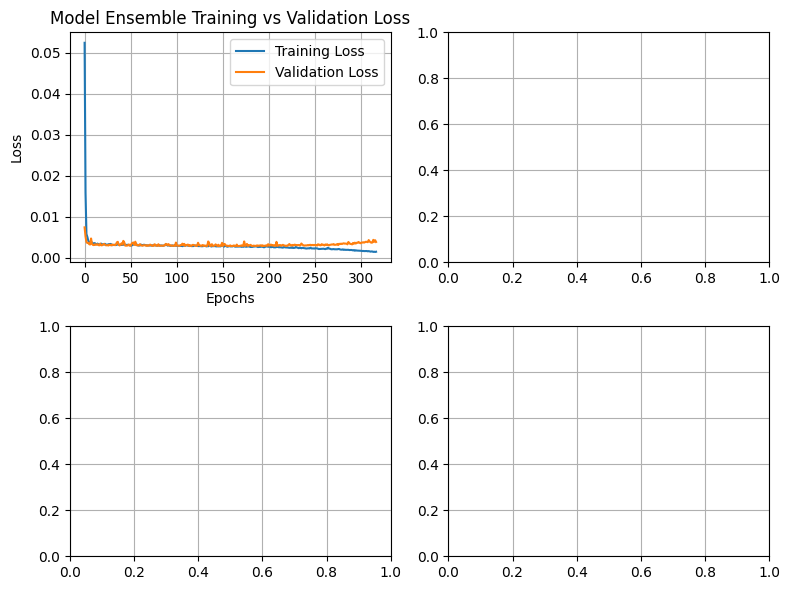

In [28]:
# Assume these are your histories
# all_history = [history_lstm, history_gru, history_bilstm, history_bigru]
all_history=[history_ens]
model_name=["Ensemble","LSTM","GRU","BiLSTM","BiGRU"]
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 6))  # One subplot per model
axs=axs.flatten()
# Loop through each history and corresponding axis
for i, history in enumerate(all_history):
    train_losses, val_losses, final_loss = history
    axs[i].plot(train_losses, label='Training Loss')
    axs[i].plot(val_losses, label='Validation Loss')
    axs[i].set_title(f'Model {model_name[i]} Training vs Validation Loss')
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Loss')
    axs[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()





# Predictions

In [29]:
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred): 
    return torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(model, test_loader):
    model.eval()
    total_loss = 0.0
    y_true_list = []
    y_pred_list = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            total_loss += loss * X_batch.size(0)

            y_true_list.append(y_batch.cpu().numpy())
            y_pred_list.append(outputs.cpu().numpy())

    avg_loss = total_loss / len(test_loader.dataset)
    
    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(torch.tensor(y_true), torch.tensor(y_pred))
    # print(f'Test Loss (MSE): {avg_loss:.4f}')
    # print(f'RMSE: {rmse:.4f}')
    # print(f'MAE: {mae:.4f}')
    # print(f'R²: {r2:.4f}')
    # print(f'MAPE: {mape:.4f}%')
    return [mape.numpy(),r2,mae,rmse,avg_loss]

# # Eval LSTM
# metrics_lstm=evaluate_model(model_lstm, test_loader)
# #Eval GRU
# metrics_gru=evaluate_model(model_gru, test_loader)
# #Eval BiLSTM
# metrics_bilstm=evaluate_model(model_bilstm, test_loader)
# # Eval BiGRU
# metrics_bigrus=evaluate_model(model_bigrus, test_loader)
#Eval Ensemble
metrics_ens=evaluate_model(ens_model, test_loader)
metrics_ens

[array(13.354476, dtype=float32),
 0.8590152277873712,
 0.053167935,
 0.07102936,
 0.005045169936548807]

In [196]:
result=pd.DataFrame( [metrics_lstm,metrics_gru,metrics_bilstm,metrics_bigrus],columns=['MAPE (%)','R²','MAE','RMSE','MSE'],index=['LSTM','GRU','BiLSTM','BiGRU'])
result


,MAPE (%),R²,MAE,RMSE,MSE
LSTM,10.914766,0.891079,0.045969,0.062432,0.003898
GRU,10.967823,0.892397,0.045021,0.062053,0.003851
BiLSTM,11.247849,0.883105,0.047522,0.064677,0.004183
BiGRU,11.680359,0.880116,0.047961,0.065499,0.004290


In [195]:
# # Evaluation pof MSE with the test_generator
# model.evaluate(test_generator,verbose=0)

# # Predictions
# predictions=model.predict(test_generator)

# # Consider the values of X_test by ignoring the first 14th
# New_X_test=X_test[:,1:][window_length:]

# # Datapredicted
# df_pred=pd.concat([pd.DataFrame(predictions),pd.DataFrame(New_X_test)],axis=1)
# # return the inverse transform of the MinMaxscaler created above to give the real value that we had initially
# rev_trans=scaler.inverse_transform(df_pred.values)

# # Extraction of the LSTM  prediction and the real value of T2M
# df_final=df_input[-predictions.shape[0]:]
# df1=df_final['T2M']
# rev2=rev_trans[:,0]

# from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,mean_absolute_percentage_error

# # Performance metrics

# mse = mean_squared_error(df1, rev2)
# r2 = r2_score(df1, rev2)
# mae = mean_absolute_error(df1, rev2)
# # mae_scaled = mean_absolute_error(X_test[-rev2.shape[0]:,0], predictions[:,0])
# mape = mean_absolute_percentage_error(df1, rev2)
# print("mse=",mse,3)
# print("r2=",r2,3)
# print("mae=",mae)
# # print("mae_scaled=" + str(round(mae_scaled,2)))
# print("mape=",mape)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

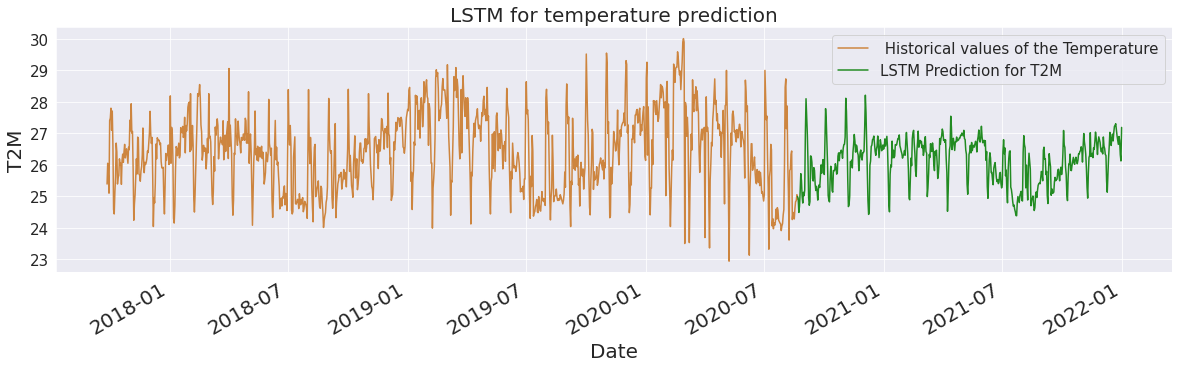

In [ ]:
# from google.colab import files

# ########## Visualization of LSTM Prediction result ##########

# dates = pd.date_range('08/21/2020', periods=498)
# dates1 = pd.date_range('01/01/2015', periods=2060)
# Forecast=pd.DataFrame({  'LSTM Prediction for T2M ':rev2})
# Forecast['date']=dates
# For=Forecast.set_index('date')
# T=df_input['T2M']
# D=T[0:2060].to_frame(' Historical values of the Temperature')
# D['Date']=dates1
# DD=D.set_index('Date')

# mpl.rcParams['xtick.labelsize'] = 20
# mpl.rcParams['ytick.labelsize'] = 15
# plt.rcParams['axes.labelsize'] = 20
# plt.rcParams['axes.titlesize'] = 20


# sns.set_style("darkgrid")
# train_forecast = pd.concat([DD,For])
# train_forecast[1000:2600].plot.line(figsize=(20, 5), color=['peru','forestgreen'])

# plt.ylabel("T2M",fontsize=20)
# plt.xlabel("Date",fontsize=20)

# plt.title("LSTM for temperature prediction")
# plt.legend(fontsize=15)
# plt.savefig('LSTM_TMP_PRED.png')
# files.download("LSTM_TMP_PRED.png")
# plt.show()



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

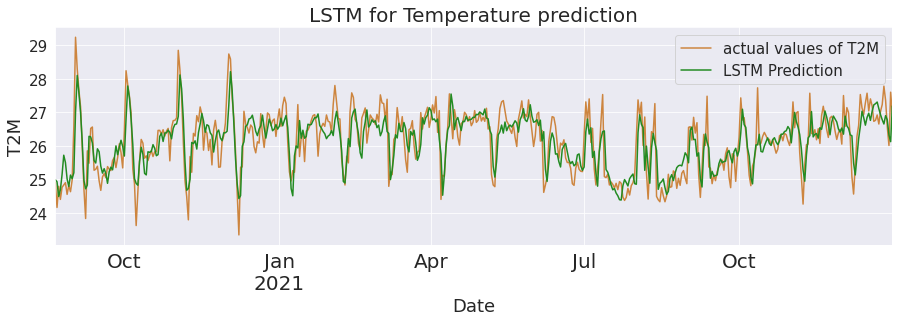

In [ ]:
# import matplotlib.dates as mdates
# Forecast=pd.DataFrame({'actual values of T2M':df1,'LSTM Prediction ':rev2})
# Forecast['date']=dates
# For=Forecast.set_index('date')
# # For.plot.line(figsize=(17, 4))
# train_forecast = pd.concat([DD,For])
# mpl.rcParams['xtick.labelsize'] = 20
# mpl.rcParams['ytick.labelsize'] = 15
# plt.rcParams['axes.labelsize'] = 20
# plt.rcParams['axes.titlesize'] = 20

# # train_forecast[2000:2600].plot.line(figsize=(15, 7))
# sns.set_style("darkgrid")

# For.plot.line(figsize=(15, 4),color=['peru','forestgreen'])
# plt.ylabel("T2M",fontsize=18)
# plt.xlabel("Date",fontsize=18)
# # dates.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# # dates.xaxis.set_major_locator(mdates.DayLocator(interval=100))
# # dates.tick_params(axis='x', labelrotation=45)
# # train_forecast.plot.line(figsize=(35, 7))
# plt.title("LSTM for Temperature prediction")
# plt.legend(fontsize=15)
# plt.savefig('LSTM_TMP_PRED_VS.png')
# files.download("LSTM_TMP_PREDx.png")
# plt.show()



In [ ]:
# plt.scatter(rev2p, df1p,s=10,linewidths=True)
# plt.ylabel(" True Precipitation values")
# plt.xlabel("Predicted Precipitation values")
# plt.title("Scatter plot")
# Concatenated predicted and real values